# Investigate Web Application Firewall (WAF) Data </br>

**Author:** Vani Asawa <br/>
**Date:** November 2020 </br>
**Notebook Version:** 1.0 <br/>
**Python Version:** Python 3.6 <br/>
**Required Packages:** msticpy, pandas, kqlmagic <br/>
**Data Sources Required:** WAF data (AzureDiagnostics) <br/>

## Overview

**Distribution of WAF logs and alerts over an extended time frame**
1. Set an extended time frame to visualise the distribution of the logs/alerts on a bar graph

**What is the distribution of WAF alerts over Rule IDs, http-status codes, and client IP entities?**
1. Set a time frame (recommended: time period of interest, after analysing the distribution of alerts in the extended time frame)
2. Pick a host entity to explore in further detail
3. Set x and y axes from the variables above, and view the number of alerts over the designate time frame.

**Cluster the request URIs in WAF Alerts, based on TFIDF scores**

*Term frequency-inverse document frequency (TFIDF)* score is a numerical statistic of how important a variable is to a document. The value of the statistic is directly proportional to the variable's frequency in the document, and inversely proportional to the number of documents that contain the variable. More information about TFIDF can be found on: https://www.researchgate.net/publication/326425709_Text_Mining_Use_of_TF-IDF_to_Examine_the_Relevance_of_Words_to_Documents

In our analysis, the *variable* will be the 'split URIs' and 'rule IDs', while a single *document* is all the blocked alerts for a single client IP in the selected time frame. We will be assessing the relative importance of every single token of the split request URIs and the number of times a ruleID is triggered for our blocked alerts over multiple such 'documents'. We will be using these two sets of scores to cluster the request URIs, and obtain single/grouped sets of interesting (and potentially malicious) request URIs that were blocked by the WAF.

1. Compute TFIDF scores based on the following 2 approaches:
    - Request URIs split on "/" against the client IP entities
    - Number of alerts for every Rule ID against the client IP entities
2. Visualising the TFIDF scores for both approaches
3. Performing DBScan Clustering + PCA to obtain the clustered and outlier request URIs for both approaches
4. KQL query to further examine the WAF logs and alerts in the time frames with outlier request URIs**

## Using the Notebook

**Prerequisites**

- msticpy - install the latest using pip install --upgrade msticpy
- pandas- install using pip install pandas
- kqlmagic

**Running the Notebook**

The best way of using the notebook is as follows:
1. Individually run all of the cells up to the start of Section 1:
    - Initialization and installation of libraries
    - Authenticating to the workspace
    - Setting notebook parameters
2. Default paramenters will allow the entire notebook to run using the 'Run Selected Cell and All Below' option under the Run tab. However, for added value, run the cells sequentially in any given section. 
    - At the beginning of each section, set the time parameters. It is recommended that the first and third section have a larger timeframe than the second and fourth sections.
    - Wait for the cell to finish running, before proceeding
    - Select the options from the widget boxes when displayed and proceed.

In [1]:
%%capture
!pip install adjustText

import sys
import os
MIN_REQ_PYTHON = (3,6)
if sys.version_info < MIN_REQ_PYTHON:
    print('Check the Kernel->Change Kernel menu and ensure that Python 3.6')
    print('or later is selected as the active kernel.')
    sys.exit("Python %s.%s or later is required.\n" % MIN_REQ_PYTHON)

from msticpy.nbtools.wsconfig import WorkspaceConfig
from msticpy.data.data_providers import QueryProvider
os.environ["KQLMAGIC_LOAD_MODE"]="silent"

import pandas as pd
from ipywidgets import widgets, interactive
from IPython.display import display
import plotly.graph_objects as go
import plotly.express as px
import numpy as np
import re
from msticpy.data.drivers.kql_driver import KqlDriver
from sklearn.feature_extraction.text import TfidfVectorizer

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from IPython.display import display, Markdown
from msticpy.nbtools import *

from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from adjustText import adjust_text
import itertools
import ipaddress

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 50)
#pd.set_option('display.max_colwidth', 100)
pd.set_option('display.max_colwidth', None)

layout = widgets.Layout(width="50%", height="80px")
style = {"description_width": "200px"}
class color:
   BOLD = '\033[1m'
   END = '\033[0m'

In [2]:
#KQL driver

#%env KQLMAGIC_LOAD_MODE=silent

tenant_id = '72f988bf-86f1-41af-91ab-2d7cd011db47'
workspace_id = '8ecf8077-cf51-4820-aadd-14040956f35d'
la_connection_string = 'loganalytics://code().tenant("' + tenant_id + '").workspace("' + workspace_id + '")'

qry_prov = QueryProvider("LogAnalytics")
qry_prov.connect(la_connection_string)

Please wait. Loading Kqlmagic extension...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Querying Function** : Accessing the results of the Kusto query as a pandas dataframe, and removing empty/null columns from the dataframe

In [3]:
def showQuery(query):
    '''
    str -> pandas.DataFrame
    
    Use KQL to query the necessary Access Logs/Firewall Logs database and return the pandas.Dataframe results
    '''
    #%kql -query query
    #df = _kql_raw_result_.to_dataframe()
    df = qry_prov.exec_query(query)
    trimDF(df)
    return df

def trimDF(df):
    ''' 
    pandas.DataFrame -> pandas.DataFrame
    
    Eliminate all columns of the pandas.Dataframe with null OR empty string '' values for all entries of the column
    '''
    # Store names of columns with null values for all entries
    empty_null_cols = [col for col in df.columns if df[col].isnull().all()]
    
    # Store names of columns with empty string '' values for all entries
    empty_str_cols = []
    for col in df.columns:
        try:
            if ''.join(df[col].map(str)) == '':
                empty_str_cols = empty_str_cols + [col]
        except:
            continue
            
    df.drop(empty_null_cols + empty_str_cols, axis=1, inplace=True)

binIntervals = ['1m', '5m', '10m', '15m', '30m', '1h', '12h', '1d', '5d', '10d']

**Selecting a Host**

In [4]:
def queryHost(startTime, endTime):
    query = '''
    AzureDiagnostics
    | where TimeGenerated between (datetime({startTime}).. datetime({endTime}))
    | where Category == "ApplicationGatewayFirewallLog"
    | where action_s == 'Blocked'
    | summarize AlertCountPerHost = count() by hostname_s, bin(timeStamp_t, {binInterval})
    | render timechart
    '''.format(startTime = startTime, endTime = endTime, binInterval = '1h')
    return(query)

**Auto determine masking bits for clubbing IPs**

In [5]:
def maskBitsVal(uniqueIPLen):
    if uniqueIPLen > 150:
        return '/8'
    elif uniqueIPLen > 40:
        return '/16'
    elif uniqueIPLen > 15:
        return '/24'
    return '/32'

## Section I: Distribution of WAF logs and blocked alerts over an extended time frame

Select an extended time frame to view the distribution of WAF logs and blocked alerts over all hosts.

In [6]:
query_times_1 = nbwidgets.QueryTime(units='day', max_before=30, before=-15, max_after=-1)
query_times_1.display()

HTML(value='<h4>Set query time boundaries</h4>')

In [7]:
categories = ['ApplicationGatewayAccessLog', 'ApplicationGatewayFirewallLog']

def viewLogs(category):
    log_alert_query = '''
    AzureDiagnostics
    | where TimeGenerated between (datetime({startTime}).. datetime({endTime}))
    | where Category == "{category}"
    | where action_s == 'Blocked' or isempty(action_s)
    | where ruleId_s != '920300'
    | summarize NoOfAlerts= count() by bin(timeStamp_t, {binInterval})
    | render timechart '''.format(startTime = query_times_1.start, endTime = query_times_1.end, category = category, binInterval = '1h')

    %kql -query log_alert_query
    
    rawDataQuery = """
    AzureDiagnostics
    | where TimeGenerated between (datetime({startTime}).. datetime({endTime}))
    | where Category == '{category}'
    | where action_s == 'Blocked' or isempty(action_s)
    | take 15
    """.format(startTime = query_times_1.start, endTime = query_times_1.end, category = category)

    display(showQuery(rawDataQuery).head(5))
    
w = interactive(viewLogs, category = widgets.Select(options = categories, style = style, layout = layout, description = 'Choose logs/alerts: '))
display(w)

interactive(children=(Select(description='Choose logs/alerts: ', layout=Layout(height='80px', width='50%'), op…

## Section II: What is the distribution of WAF alerts over Rule IDs, http-status codes, and client IP Entities?

Select a time frame of interest to view the distribution of WAF blocked alerts over all hosts.

In [8]:
query_times_2 = nbwidgets.QueryTime(units='day', max_before=30, before=-10, max_after=-1)
query_times_2.display()

HTML(value='<h4>Set query time boundaries</h4>')

### Select a host entity

The following host entity will be used for the remainder of this section

<IPython.core.display.Javascript object>

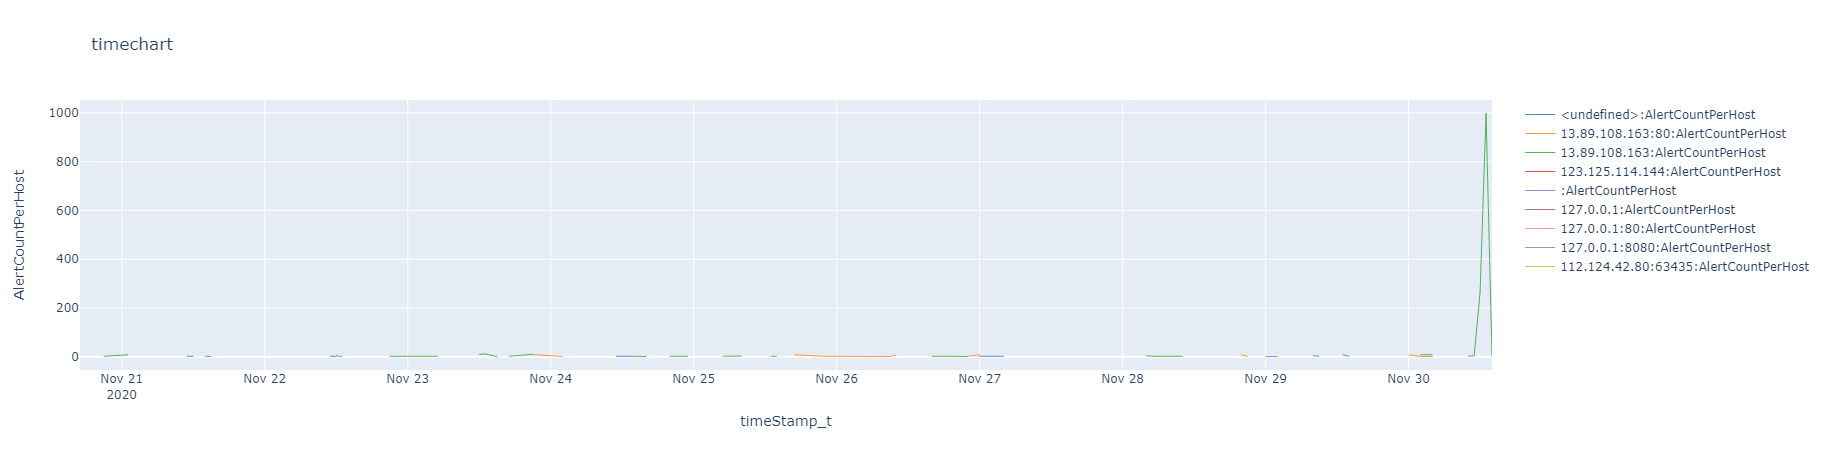

<IPython.core.display.Javascript object>

,Num_blocked_alerts
hostname_s,
,9
112.124.42.80:63435,1
123.125.114.144,1
127.0.0.1,6
127.0.0.1:80,3
127.0.0.1:8080,6
13.89.108.163,2374
13.89.108.163:80,157
<undefined>,50


Select(description='Select Host: ', index=4, layout=Layout(height='80px', width='50%'), options=('', '13.89.10…

In [9]:
query = queryHost(query_times_2.start, query_times_2.end)
%kql -query query

try:
    df_host = showQuery(query)
    list_hosts = set([x for x in df_host['hostname_s']])
    df = df_host.groupby(['hostname_s']).agg({'AlertCountPerHost': sum}).rename(columns = {'AlertCountPerHost': 'Num_blocked_alerts'})
    hosts = widgets.Select(options=list_hosts, style = style, layout = layout, value=df['Num_blocked_alerts'].idxmax(), description = 'Select Host: ')
    display(df)
    display(hosts)
except Exception as e:
    print('Error: ' + e)
    traceback.print_exc()

### Render visualisations of the distribution of alerts for the selected host

We will be using balloon plots to visualise the number of WAF alerts over rule IDs, http-status codes, and client IP entities, for the selected host entity.

In [10]:
query_distribution = '''
AzureDiagnostics
| where TimeGenerated between (datetime({startTime}).. datetime({endTime}))
| where Category == "ApplicationGatewayFirewallLog"
| where hostname_s == "{host}"
| where ruleId_s != '920300'
| join kind=leftouter ( AzureDiagnostics
| where TimeGenerated between  (datetime({startTime}).. datetime({endTime}))
| where Category == "ApplicationGatewayAccessLog"
| summarize by requestUri_s, httpStatus_d
) on requestUri_s 
| summarize NoOfAlerts = count(), make_set(requestUri_s), DistinctURIs = dcount(requestUri_s) by clientIp_s, ruleId_s, httpStatus_d1
'''.format(startTime = query_times_2.start, endTime = query_times_2.end, host = hosts.value)

try:
    df_distribution = showQuery(query_distribution)
    df_distribution.rename(columns = {'clientIp_s':'Ip Address', 'ruleId_s':'Rule ID', 'set_requestUri_s': 'Request Uris'}, inplace = True)

    if 'httpStatus_d1' in df_distribution.columns:
        df_distribution = df_distribution.sort_values(by=['httpStatus_d1'], ascending = True).reset_index(drop = True)
        df_distribution.rename(columns = {'httpStatus_d1':'Http status'}, inplace = True) 
        df_distribution['Http status'] = 'h: ' + df_distribution['Http status'].astype(str)
    
    maskBits = maskBitsVal(len(df_distribution['Ip Address'].unique()))
    df_distribution['Ip Address'] = df_distribution['Ip Address'].apply(lambda x: ipaddress.IPv4Network(x + maskBits, strict = False))
    
    df_distribution['Ip Address'], df_distribution['Rule ID'] =  'Ip ' + df_distribution['Ip Address'].astype(str), 'rID ' + df_distribution['Rule ID'].astype(str)
except Exception as e:
    print('Error: ' + e)
    traceback.print_exc()

<IPython.core.display.Javascript object>

In [11]:
import traceback
options = ['Ip Address', 'Rule ID']
if 'Http status' in df_distribution.columns:
    options += ['Http status']

def viewBalloonPlot(x_axis, y_axis, display_rawResult):
    try:   
        df_balloon_plot = (df_distribution
                  .groupby([x_axis, y_axis], as_index=False)
                  .agg({'NoOfAlerts': sum, 'DistinctURIs': sum, 'Request Uris': list})
                  .reset_index(drop = True))
        fig = px.scatter(df_balloon_plot,   x=df_balloon_plot[x_axis], y = df_balloon_plot[y_axis], 
                     size= np.log(1 + df_balloon_plot['NoOfAlerts'] ), color = 'NoOfAlerts',
                     hover_data=['NoOfAlerts', 'DistinctURIs']) 

        fig.update_layout(height = max(300, 30 * len(set(df_balloon_plot[y_axis]))), title_text='Alert Distribution for host ID '+ str(hosts.value))

        fig.show()
        if display_rawResult == 'Yes':
            print('Top 5 raw results with the highest number of alerts: \n')
            df_balloon_plot['Request Uris'] = [np.unique(list(itertools.chain(*row['Request Uris']))) for index, row in df_balloon_plot.iterrows() ]
            df_balloon_plot['DistinctURIs'] = df_balloon_plot['Request Uris'].str.len()
            display(df_balloon_plot[[y_axis, x_axis, 'NoOfAlerts','Request Uris', 'DistinctURIs']].sort_values(by='NoOfAlerts', ascending = False).head(5))
    except ValueError:
        print('ValueError: Choose distinct x and y axes')
    except Exception as e:
        print('Error: ' + e)
        traceback.print_exc()
        

w = interactive(viewBalloonPlot, x_axis = widgets.Select(options = options, style = style, layout = layout, description = 'Select x-axis: '), 
                   y_axis = widgets.Select(options = options, style = style, layout = layout, description = 'Select y-axis: '), display_rawResult = widgets.Select(options = ['Yes', 'No'], style = style, layout = layout, description = 'Display raw result?: '))

display(w)

interactive(children=(Select(description='Select x-axis: ', layout=Layout(height='80px', width='50%'), options…

## Section III: Cluster the request URIs in WAF Alerts, based on TFIDF scores

Select the timeframe and host entity for this section of the notebook

In [12]:
query_times_3 = nbwidgets.QueryTime(units='day', max_before=30, before=10, max_after=-1)
query_times_3.display()

HTML(value='<h4>Set query time boundaries</h4>')

In [13]:
df_host_2 = showQuery(queryHost(query_times_3.start, query_times_3.end))
df = df_host_2.groupby(['hostname_s']).agg({'AlertCountPerHost': sum}).rename(columns = {'AlertCountPerHost': 'Num_blocked_alerts'})
hosts_2 = widgets.Select(options=set([x for x in df_host_2['hostname_s']]), value=df['Num_blocked_alerts'].idxmax(), description = 'Select Host: ')
display(df)
display(hosts_2)

<IPython.core.display.Javascript object>

,Num_blocked_alerts
hostname_s,
,9
112.124.42.80:63435,1
123.125.114.144,1
127.0.0.1,6
127.0.0.1:80,3
127.0.0.1:8080,6
13.89.108.163,2374
13.89.108.163:80,157
<undefined>,50


Select(description='Select Host: ', index=4, options=('', '13.89.108.163:80', '112.124.42.80:63435', '127.0.0.…

**Enter min_df and max_df value parameters**

For more information about these parameters in the TFIDF vectorizer, please see https://stackoverflow.com/questions/27697766/understanding-min-df-and-max-df-in-scikit-countvectorizer
If you would like to view the TFIDF scores for all the data, change the following code in the `tfidfScores` function:

`vectorizer = TfidfVectorizer(tokenizer=identity_tokenizer, lowercase=False, min_df = min_df_value, max_df = max_df_value)   `

to

`vectorizer = TfidfVectorizer(tokenizer=identity_tokenizer, lowercase=False)  ` 



In [14]:
min_df_widget = widgets.Text(style = style, layout = widgets.Layout(width="50%", height="30px"), description = 'Enter min_df: ', placeholder = '% or Integer or None', value = '0.01')
max_df_widget = widgets.Text(style = style, layout = widgets.Layout(width="50%", height="30px"), description = 'Enter max_df: ', placeholder = '% or Integer or None', value = '0.9')

display(min_df_widget)
display(max_df_widget)

Text(value='0.01', description='Enter min_df: ', layout=Layout(height='30px', width='50%'), placeholder='% or …

Text(value='0.9', description='Enter max_df: ', layout=Layout(height='30px', width='50%'), placeholder='% or I…

In [15]:
try:
    min_df_value = float(min_df_widget.value)
    max_df_value = float(max_df_widget.value)
except Exception as e:
    print('Error: ' + str(e))
    traceback.print_exc()
    
def tfidfScores(df, tokenList = None):
    def identity_tokenizer(text):
        return text
    
    vectorizer = TfidfVectorizer(tokenizer=identity_tokenizer, lowercase=False, min_df = min_df_value, max_df = max_df_value)    
    vectors = vectorizer.fit_transform(tokenList)
    feature_names = vectorizer.get_feature_names()
    dense = vectors.todense()
    denselist = dense.tolist()
    df_scores = pd.DataFrame(denselist, columns = feature_names)
    multicol1 = pd.MultiIndex.from_tuples([('weight', str(j)) for j in df_scores.columns])
    df_multiIndex = pd.DataFrame([list(df_scores.iloc[i]) for i in range(0, len(df_scores))], index=[df['Ip Address']], columns=multicol1)
    return df_multiIndex

### Approach I: Compute TFIDF scores for split request URIs in the blocked WAF Alerts against client IP entities

In [16]:
query_URIs = '''
AzureDiagnostics
| where TimeGenerated between (datetime({startTime}).. datetime({endTime}))
| where Category == "ApplicationGatewayFirewallLog"
| where hostname_s startswith "{host}"
//| where ruleId_s != '920300'
| where action_s == 'Blocked'
| distinct clientIp_s, requestUri_s
| summarize make_list(requestUri_s) by clientIp_s
'''.format(startTime = query_times_3.start, endTime = query_times_3.end, host = hosts_2.value)

try:
    df_URIs = showQuery(query_URIs)
    df_URIs.rename(columns = {'clientIp_s':'Ip Address', 'list_requestUri_s': 'RequestUris'}, inplace = True) 

    viewData_splitUri = df_URIs.copy()
    maskBits = maskBitsVal(len(viewData_splitUri['Ip Address'].unique()))
    viewData_splitUri['Ip Address'] = viewData_splitUri['Ip Address'].apply(lambda x: ipaddress.IPv4Network(x + maskBits, strict = False))
    viewData_splitUri.groupby(["Ip Address"], as_index=False).agg({'RequestUris': list})

    tokenList = []
    for index, row in viewData_splitUri.iterrows():
        splitUris = re.split('/', ''.join(row['RequestUris']))
        tokenList = tokenList + [splitUris] 

    df_splitUri_tfidf = tfidfScores(viewData_splitUri, tokenList)
    display(df_splitUri_tfidf.head(5))
except Exception as e:
    print('Error: ' + str(e))
    traceback.print_exc()

<IPython.core.display.Javascript object>

weight                              \
                !.php ${@die(md5(HelloThinkPHP))}   
Ip Address                                          
13.92.0.0/16      0.0                         0.0   
172.105.0.0/16    0.0                         0.0   
111.230.0.0/16    0.0                         0.0   
91.241.0.0/16     0.0                         0.0   
203.115.0.0/16    0.0                         0.0   

                                                                           \
               %68%74%6D%6C%6F%66%66%69%63%65%73%65%72%76%6C%65%74 %69%6D   
Ip Address                                                                  
13.92.0.0/16                                                   0.0    0.0   
172.105.0.0/16                                                 0.0    0.0   
111.230.0.0/16                                                 0.0    0.0   
91.241.0.0/16                                                  0.0    0.0   
203.115.0.0/16                                                 0.0    0.0   

                                      \
               %69%73%70%69%72%69%74   
Ip Address                             
13.92.0.0/16                     0.0   
172.105.0.0/16                   0.0   
111.230.0.0/16                   0.0   
91.241.0.0/16                    0.0   
203.115.0.0/16                   0.0   

                                                                                                                                                                                                                                                                                        \
               %72%65%67%69%73%74%65%72?%65%6c%65%6d%65%6e%74%5f%70%61%72%65%6e%74%73=%74%69%6d%65%7a%6f%6e%65%2f%74%69%6d%65%7a%6f%6e%65%2f%23%76%61%6c%75%65\u0026%61%6a%61%78%5f%66%6f%72%6d=1\u0026%5f%77%72%61%70%70%65%72%5f%66%6f%72%6d%61%74=%64%72%75%70%61%6c%5f%61%6a%61%78   
Ip Address                                                                                                                                                                                                                                                                               
13.92.0.0/16                                                                                                                                                                                                                                                                       0.0   
172.105.0.0/16                                                                                                                                                                                                                                                                     0.0   
111.230.0.0/16                                                                                                                                                                                                                                                                     0.0   
91.241.0.0/16                                                                                                                                                                                                                                                                      0.0   
203.115.0.0/16                                                                                                                                                                                                                                                                     0.0   

                                                                               \
               %73%65%65%79%6F%6E %75%70%6C%6F%61%64%2E%70%68%70 %75%73%65%72   
Ip Address                                                                      
13.92.0.0/16                  0.0                            0.0          0.0   
172.105.0.0/16                0.0                            0.0       

### Approach II: Computer TFIDF scores for volume of blocked WAF alerts for Rule Ids against the client IP entities

In [17]:
query_RuleIds = '''
AzureDiagnostics
| where TimeGenerated between (datetime({startTime}).. datetime({endTime}))
| where Category == "ApplicationGatewayFirewallLog"
| where hostname_s startswith "{host}"
| where action_s == 'Blocked'
//| where ruleId_s != '920300'
| summarize alertCount = count(), make_set(requestUri_s) by clientIp_s, ruleId_s
'''.format(startTime = query_times_3.start, endTime = query_times_3.end, host = hosts_2.value)

try:
    dfPrac = showQuery(query_RuleIds)
    df_RuleIds = showQuery(query_RuleIds)
    df_RuleIds.rename(columns = {'clientIp_s':'Ip Address', 'ruleId_s':'RuleId', 'set_requestUri_s': 'RequestUris'}, inplace = True) 
    
    maskBits = maskBitsVal(len(df_RuleIds['Ip Address'].unique()))
    df_RuleIds['Ip Address'] = df_RuleIds['Ip Address'].apply(lambda x: ipaddress.IPv4Network(x + maskBits, strict = False))

    viewData_ruleId = df_RuleIds.groupby(["Ip Address"], as_index=False).agg({'RuleId': list, 'alertCount': list, 'RequestUris': list})
    tokenList = [sum([[s] * n for s, n in zip(viewData_ruleId['RuleId'][x], viewData_ruleId['alertCount'][x])], []) for x in range(0, len(viewData_ruleId))]

    df_ruleId_tfidf = tfidfScores(viewData_ruleId, tokenList)
    display(df_ruleId_tfidf.head(5))
except Exception as e:
    print('Error: ' + e)
    traceback.print_exc()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

weight                                                        
                949110    980130 BlockGeoLocationChina BlockInternetExplorer11
Ip Address                                                                    
1.192.0.0/16  0.000000  0.000000                   1.0                     0.0
3.81.0.0/16   0.707107  0.707107                   0.0                     0.0
3.229.0.0/16  0.707107  0.707107                   0.0                     0.0
13.65.0.0/16  0.707107  0.707107                   0.0                     0.0
13.68.0.0/16  0.707107  0.707107                   0.0                     0.0

### Visualisation of the TFIDF scores for both approaches

We will be using balloon plots to view the TFIDF scores for the two approaches

In [18]:
options = ['RuleId', 'SplitUris']

def visualiseTFIDF(TfidfCategory):
    try:
        max_category = 30
        df = pd.DataFrame()
        if TfidfCategory == 'RuleId': df = df_ruleId_tfidf.copy()
        else: df = df_splitUri_tfidf.copy()

        df_tfidf = df.iloc[:, : max_category].stack().reset_index(drop = False).rename(columns = {'level_1':TfidfCategory, 'weight':'tfidf'})
        df_tfidf['Ip Address'] = 'Ip ' + df_tfidf['Ip Address'].astype(str)
        if 'RuleId' == TfidfCategory: df_tfidf['RuleId'] = 'rID ' + df_tfidf['RuleId'].astype(str)
        fig = px.scatter(df_tfidf,  x = df_tfidf[TfidfCategory], y = df_tfidf['Ip Address'],
                     size= np.log(1 + df_tfidf['tfidf']), color = df_tfidf['tfidf'],
                     hover_data=[df_tfidf['tfidf']]) 
        fig.update_layout(height = max(800, 20 * len(set(df_tfidf[TfidfCategory]))), title_text= 'TFIDF distribution of ' +  TfidfCategory + ' against client IPs', width = 1700)
        fig.show()
        display(df.head(10))
    except Exception as e:
        print('Error: ' + e)
        traceback.print_exc()
    
display(interactive(visualiseTFIDF, TfidfCategory = widgets.Select(options = options, style = style, layout = layout, description = 'TFIDF approach: ')))

interactive(children=(Select(description='TFIDF approach: ', layout=Layout(height='80px', width='50%'), option…

### DBSCAN Clustering and PCA of the request URIs for both approaches

DBSCAN is a non-parametric density-based spatial clustering algorithm, which groups together points that are "closely packed" together. Points which lie in low density regions are marked as outliers. For more information, please see https://www.aaai.org/Papers/KDD/1996/KDD96-037.pdf.

In [19]:
def determineEps(data):
    from sklearn.neighbors import NearestNeighbors
    nearest_neighbors = NearestNeighbors(n_neighbors=5)
    nearest_neighbors.fit(data)
    distances, indices = nearest_neighbors.kneighbors(data)
    distances = np.sort(distances, axis=0)[:, 1]
    print(distances)
    plt.plot(distances)
    plt.show()

def DBScanClustering(data, eps = 0.4):
    dbscan = DBSCAN(eps=eps, min_samples = 5)
    dbscan.fit(data)
    return dbscan.labels_
    
def PrincipalComponentAnalysis(data, eps = 0.4):
    while True: 
        try: 
            pca = PCA(n_components=2)
            pca.fit(data)
            x_pca = pca.transform(data)
            break 
        except: 
            continue
    clusters = DBScanClustering(data.values, eps)
    
    label = list(range(0, len(data), 1))
    plt.figure(figsize=(20,15))
    scatter = plt.scatter(x_pca[:,0],x_pca[:,1],c = clusters,cmap='rainbow')
    handles, labels = scatter.legend_elements(prop="colors", alpha=0.6)
    plt.legend(handles, labels, loc="upper right", title="Clusters")
    n = list(range(0, len(x_pca[:,0]), 1))
    texts = []
    for i, txt in enumerate(n):
        texts.append(plt.text(x_pca[:,0][i], x_pca[:,1][i], txt))
    adjust_text(texts)

    plt.show()

In [20]:
options1 = ['RuleId', 'SplitUris']

def viewPCA(tfidfCategory):
    df = df_splitUri_tfidf.copy()
    viewData = viewData_splitUri.copy()
    if tfidfCategory == 'RuleId': 
        df = df_ruleId_tfidf.copy()
        viewData = viewData_ruleId.copy()

    print(tfidfCategory + ' approach (Outliers + Clustered request URI data): \n')
    while True:
        try:
            PrincipalComponentAnalysis(df)
            break
        except:
            continue
    
print(color.BOLD + 'Principal Component Analysis \n' + color.END)
display(interactive(viewPCA, tfidfCategory = widgets.Select(options = options1, style = style, layout = layout, description = 'TFIDF approach: ')))    

Principal Component Analysis 



interactive(children=(Select(description='TFIDF approach: ', layout=Layout(height='80px', width='50%'), option…

In [21]:
options1 = ['RuleId', 'SplitUris']
options2 = ['Outlier', 'Clustered']

def viewClusters(tfidfCategory, requestURIs):
    try:
        df = df_splitUri_tfidf.copy()
        viewData = viewData_splitUri.copy()
        if tfidfCategory == 'RuleId': 
            df = df_ruleId_tfidf.copy()
            viewData = viewData_ruleId.copy()

        #print('Principal Component Analysis for ' + tfidfCategory + ' approach (Outliers + Clustered request URI data): \n')
         #PrincipalComponentAnalysis(df)

        clusters = DBScanClustering(df.values)
        print(requestURIs + ' URIs for ' + tfidfCategory+ ': \n')

        clusterList = list(set(clusters))
        try:
            clusterList.remove(-1)
        except:
            print()

        if requestURIs == 'Outlier':
            clusterList = [-1]

        if clusterList:
            for k in clusterList:
                print('Cluster ' + str(k))
                display(viewData[viewData['Ip Address'].isin(df.index.get_level_values(0)[clusters == k])])
        else:
            print('No Data')
    except Exception as e:
        print('Error: ' + e)
        traceback.print_exc()

print(color.BOLD + 'DBScan Clustering of the Request URIs \n' + color.END)
display(interactive(viewClusters, tfidfCategory = widgets.Select(options = options1, style = style, layout = layout, description = 'TFIDF approach: '), requestURIs = widgets.Select(options = options2, style = style, layout = layout, description = 'Request URIs: ') ))

DBScan Clustering of the Request URIs 



interactive(children=(Select(description='TFIDF approach: ', layout=Layout(height='80px', width='50%'), option…

### Kusto query to further examine the WAF logs and alerts in the time frames with outlier request URIs

In [22]:
ipAddress = widgets.Text(style = style, layout = widgets.Layout(width="50%", height="30px"), description = 'IP address: ', placeholder = 'Enter masked IP address from the results above. Include masking bits.')
requestURI = widgets.Text(style = style, layout = widgets.Layout(width="50%", height="30px"), description = 'Request URI: ', placeholder = 'Enter request URI from the results above')

print(color.BOLD + '\nStart time: ' + color.END + str(query_times_3.start) + '\n')
print(color.BOLD + 'End time: ' + color.END + str(query_times_3.end) + '\n')

display(ipAddress)
display(requestURI)


Start time: 2020-11-20 15:03:34.308267

End time: 2020-12-01 15:03:34.308267



Text(value='', description='IP address: ', layout=Layout(height='30px', width='50%'), placeholder='Enter maske…

Text(value='', description='Request URI: ', layout=Layout(height='30px', width='50%'), placeholder='Enter requ…

In [25]:
try:
    kql_query = '''
    AzureDiagnostics
    | where TimeGenerated between (datetime({startTime}).. datetime({endTime}))
    | where Category == "{category}"
    | where {hostname} startswith "{host}" 
    | where action_s == 'Blocked' or isempty(action_s)
    //| where ruleId_s != '920300'
    | where {ip} startswith "{ipaddress}"
    | extend originalRequestUriWithArgs_s = column_ifexists("originalRequestUriWithArgs_s", "")
    | where requestUri_s contains {uri} or originalRequestUriWithArgs_s contains {uri}
    | take 10
    '''
    cutOff = [1, 2, 3, 4]
    intlist = [8, 16, 24, 32]
    
    if ipAddress.value != '':
        ipaddress = str(ipAddress.value).strip().split('/')[0]
        maskBits =  int(str(ipAddress.value).strip().split('/')[1])
        ipaddress = '.'.join(ipaddress.split('.')[0:cutOff[intlist.index(maskBits)]])
    else:
        ipaddress = ''
        
    print(color.BOLD + '\nStart time: ' + color.END + str(query_times_3.start) + '\n')
    print(color.BOLD + 'End time: '+ color.END + str(query_times_3.end) + '\n')
    
    print(color.BOLD + 'Ip Address entered: ' + color.END + str(ipAddress.value) + '\n')
    print(color.BOLD  + 'Request Uri entered: ' + color.END + str((requestURI.value).strip()) + '\n' )
    
    category = 'ApplicationGatewayAccessLog'
    ip_var = 'clientIP_s'
    host_var = 'host_s'
    uri = '\'' + (requestURI.value).strip() +  '\''
    kql_accessLogs = kql_query.format(hostname = host_var, startTime = query_times_3.start, endTime = query_times_3.end, host = hosts_2.value, category = category, ip = ip_var, ipaddress = ipaddress, uri = uri)
    df_rawAccessKustoQuery = showQuery(kql_accessLogs)
    print(category + ' (Raw) Data- \n')
    display(df_rawAccessKustoQuery.head(10))
    
    category = 'ApplicationGatewayFirewallLog'
    ip_var = 'clientIp_s'
    host_var = 'hostname_s'
    uri = '@' + '\'' + (requestURI.value).strip() +  '\''
    kql_firewallLogs = kql_query.format(hostname = host_var, startTime = query_times_3.start, endTime = query_times_3.end, host = hosts_2.value, category = category, ip = ip_var, ipaddress = ipaddress, uri = uri,)
    df_rawFirewallKustoQuery = showQuery(kql_firewallLogs)
    print(category + ' (Alert) Data- \n')
    display(df_rawFirewallKustoQuery.head(10))
    
except Exception as e:
    print('Error: ' + str(e))
    traceback.print_exc()


Start time: 2020-11-20 15:03:34.308267

End time: 2020-12-01 15:03:34.308267

Ip Address entered: 43.226.0.0/16

Request Uri entered: /text.php



<IPython.core.display.Javascript object>

ApplicationGatewayAccessLog (Raw) Data- 



,TenantId,TimeGenerated,ResourceId,Category,ResourceGroup,SubscriptionId,ResourceProvider,Resource,ResourceType,OperationName,requestUri_s,userAgent_s,ruleName_s,httpMethod_s,instanceId_s,httpVersion_s,clientIP_s,host_s,clientPort_d,httpStatus_d,receivedBytes_d,sentBytes_d,timeTaken_d,SourceSystem,listenerName_s,backendPoolName_s,backendSettingName_s,transactionId_g,timeStamp_t,originalRequestUriWithArgs_s,originalHost_s,Type,_ResourceId
0,8ecf8077-cf51-4820-aadd-14040956f35d,2020-11-28 21:40:24.660000+00:00,/SUBSCRIPTIONS/D1D8779D-38D7-4F06-91DB-9CBC8DE0176F/RESOURCEGROUPS/SOC-NS/PROVIDERS/MICROSOFT.NETWORK/APPLICATIONGATEWAYS/SOC-NS-AG-WAFV2,ApplicationGatewayAccessLog,SOC-NS,d1d8779d-38d7-4f06-91db-9cbc8de0176f,MICROSOFT.NETWORK,SOC-NS-AG-WAFV2,APPLICATIONGATEWAYS,ApplicationGatewayAccess,/text.php,"Mozilla/5.0 (Windows NT 6.1; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/49.0.2623.105 Safari/537.36",PublicIPRule,GET,appgw_1,HTTP/1.1,43.226.40.197,13.89.108.163,48241.0,403.0,224.0,762.0,0.0,Azure,Public-HTTP,PAAS-APP,Default,20bb559e-cb85-caeb-ffa6-2d1e292168a8,2020-11-28 21:39:00+00:00,/text.php,13.89.108.163,AzureDiagnostics,/subscriptions/d1d8779d-38d7-4f06-91db-9cbc8de0176f/resourcegroups/soc-ns/providers/microsoft.network/applicationgateways/soc-ns-ag-wafv2


<IPython.core.display.Javascript object>

ApplicationGatewayFirewallLog (Alert) Data- 



,TenantId,TimeGenerated,ResourceId,Category,ResourceGroup,SubscriptionId,ResourceProvider,Resource,ResourceType,OperationName,requestUri_s,Message,instanceId_s,SourceSystem,engine_s,ruleSetType_s,ruleId_s,action_s,hostname_s,transactionId_g,policyId_s,policyScope_s,policyScopeName_s,timeStamp_t,clientIp_s,Type,_ResourceId
0,8ecf8077-cf51-4820-aadd-14040956f35d,2020-11-28 21:40:26.555000+00:00,/SUBSCRIPTIONS/D1D8779D-38D7-4F06-91DB-9CBC8DE0176F/RESOURCEGROUPS/SOC-NS/PROVIDERS/MICROSOFT.NETWORK/APPLICATIONGATEWAYS/SOC-NS-AG-WAFV2,ApplicationGatewayFirewallLog,SOC-NS,d1d8779d-38d7-4f06-91db-9cbc8de0176f,MICROSOFT.NETWORK,SOC-NS-AG-WAFV2,APPLICATIONGATEWAYS,ApplicationGatewayFirewall,/text.php,"Found condition 0 in RemoteAddr, with value 43.226.40.197 (CN).",appgw_1,Azure,Azwaf,Custom,BlockGeoLocationChina,Blocked,13.89.108.163,20bb559e-cb85-caeb-ffa6-2d1e292168a8,2#default,Global,Global,2020-11-28 21:39:00+00:00,43.226.40.197,AzureDiagnostics,/subscriptions/d1d8779d-38d7-4f06-91db-9cbc8de0176f/resourcegroups/soc-ns/providers/microsoft.network/applicationgateways/soc-ns-ag-wafv2
